In [19]:
# Copy test file and run workflow
!cp data/test_epic_data.fastq.gz ../data/fastq/
!time snakemake --cores all --use-conda --snakefile ../workflow/Snakefile --directory ../ 

Multiple includes of /local/work/adrian/ERMA/workflow/rules/qc.smk ignored
Run: test with detected sequence technology: ONT
Detected samples: ['test_epic_data']
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 64
Rules claiming more threads will be scaled down.
Job stats:
job                                 count    min threads    max threads
--------------------------------  -------  -------------  -------------
abundance_bubble_plot                   1             32             32
all                                     1              1              1
blast_card                              2             32             32
convert_fastq_to_fasta                  1              1              1
decompress_fastq                        1              1              1
fastqc                                  1              8              8
filter_blast_results                    2             32             32
genera_abundance_table                  1             32     

In [5]:
# 1. Step similarity search
# Input: split fasta files
# Output: tabular similarity search results
# commands:
# usearch vs silva_v138.2 database (778 MB unzipped): usearch -usearch_local {input.fasta} -db {input.silva} -blast6out {output.silva_results} -evalue 1e-5 -threads {params.internal_threads} -strand plus -mincols 200 2> {log}
# blastx vs card_v3.3.0 database (4.8 MB unzipped): blastx -query {input.fasta} -db {params.db}/card_db -out {output.card_results} -outfmt 6 -evalue 1e-5 -num_threads {params.internal_threads} 2> {log}

import os,pathlib,pandas as pd
from IPython.display import display, Markdown

path = os.path.dirname(pathlib.Path().resolve())

silva_result = os.path.join(path,"results","test_epic_data","001","SILVA_results.txt.gz")
card_result = os.path.join(path,"results","test_epic_data","001","card_results.txt.gz")
string1 = "blastx -query {input.fasta} -db {params.db}/card_db -out {output.card_results} -outfmt 6 -evalue 1e-5 -num_threads {params.internal_threads} 2> {log}"
string2 = "usearch -usearch_local {input.fasta} -db {input.silva} -blast6out {output.silva_results} -evalue 1e-5 -threads {params.internal_threads} -strand plus -mincols 200 2> {log}"

blast_columns = ["query_id", "subject_id", "perc_identity", "align_length", "mismatches","gap_opens", "q_start", "q_end", "s_start", "s_end", "evalue", "bit_score"]

for i in [[card_result,"Card Similarity Search Result (BLASTX)",string1],[silva_result,"Silva Similarity Search Result (usearch)",string2]]:
    df = pd.read_csv(i[0],names=blast_columns,compression='gzip',sep='\t')
    summary = df.agg({"perc_identity": ["mean", "min", "max"],"align_length": ["mean", "min", "max"],"evalue": ["mean", "min", "max"]}).style.format({"perc_identity": "{:.2f}","align_length": "{:.2f}","evalue": "{:.2e}"})
    
    display(Markdown(f"## {i[1]}"))
    display(Markdown(f" ```{i[2]}```"))
    display(Markdown(f" Shape: {df.shape}"))
    display(summary)    
    display(df.head(2))
    display(Markdown("---"))

## Card Similarity Search Result (BLASTX)

 ```blastx -query {input.fasta} -db {params.db}/card_db -out {output.card_results} -outfmt 6 -evalue 1e-5 -num_threads {params.internal_threads} 2> {log}```

 Shape: (127693, 12)

,perc_identity,align_length,evalue
mean,73.94,39.92,2.17e-07
min,20.00,7.00,6.94e-38
max,100.00,111.00,1.00e-05


,query_id,subject_id,perc_identity,align_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,92ab8f0f-4af2-463d-bebc-5437988c2a71,gb|WP_140423324.1|ARO:3006030|OXA-833,86.111,36,5,0,167,60,35,70,8.980000e-20,65.1
1,92ab8f0f-4af2-463d-bebc-5437988c2a71,gb|WP_140423324.1|ARO:3006030|OXA-833,67.647,34,10,1,267,166,3,35,8.980000e-20,45.8


---

## Silva Similarity Search Result (usearch)

 ```usearch -usearch_local {input.fasta} -db {input.silva} -blast6out {output.silva_results} -evalue 1e-5 -threads {params.internal_threads} -strand plus -mincols 200 2> {log}```

 Shape: (812, 12)

,perc_identity,align_length,evalue
mean,91.87,272.71,8.99e-19
min,79.30,201.00,9.80e-143
max,99.30,332.00,5.70e-16


,query_id,subject_id,perc_identity,align_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,a2b699ad-4366-417b-bca1-c581eb29da90 runid=520...,FJ445213.1.2097 Bacteria;Pseudomonadota;Gammap...,89.7,291,10,8,91,373,681,959,4.100000e-72,276.3
1,ceb6ff52-c7ff-46cd-b3cf-9c2b7724967d runid=520...,FJ445213.1.2097 Bacteria;Pseudomonadota;Gammap...,96.8,277,3,4,111,382,684,959,1.400000e-111,407.4


---

In [6]:
# 2. Integrate similarity search results
# Selfwritten python script "integrate_blast_data.py"
# Input: blastx, usearch results, ARO Mapping file
# Output: Processed integrated search results

aro_mapping = os.path.join(path, "data", "card_db", "aro_index.tsv")
aro_df = pd.read_csv(aro_mapping, sep="\t")

int_result = os.path.join(path, "results", "test_epic_data", "001", "integrated_filtered_results.csv")
int_df = pd.read_csv(int_result, sep=",", low_memory=False)

display(Markdown(f"""
# Integrating information
## Mapping input: ARO File
- Shape: {aro_df.shape}\n
- Mapping to CARD results: ```df.merge(aro_df, on='ARO Accession', how='left')```
---
"""))

display(aro_df[aro_df["AMR Gene Family"] == "OXA beta-lactamase;OXA-48-like beta-lactamase"].head(2))

rows_16s = len(int_df[int_df["part"] == '16S'])
rows_abr = len(int_df[int_df["part"] == 'ABR'])
orientation_counts = int_df['orientation'].value_counts().to_dict()
subject_id_16 = int_df[int_df["part"] == "16S"]["subject_id"].iloc[0]
subject_id_abr = int_df[int_df["part"] == "ABR"]["subject_id"].iloc[0]

display(Markdown(f"""
## Additional Information Added
---
### 1. Adding 16S/ABR Rows
- Rows with 16S: **{rows_16s}**
- Rows with ABR: **{rows_abr}**

### 2. Orientation of Queries (Abandoned)
- Unique query orientations with counts:
  ```{orientation_counts}```
### 3. Adding Column for Relevant Information of subject_id
{subject_id_16.split(";")[-2]} <--- {subject_id_16}\n
{subject_id_abr.split("|")[-2]} <--- {subject_id_abr}
"""))

part_16S = int_df[int_df["part"] == '16S'].head(1)
part_ABR = int_df[int_df["part"] == 'ABR'].head(1)
summary = int_df.agg({"perc_identity": ["mean", "min", "max"],"align_length": ["mean", "min", "max"],"evalue": ["mean", "min", "max"]}).style.format({"perc_identity": "{:.2f}","align_length": "{:.0f}","evalue": "{:.2e}"})

display(Markdown(f"""
## Integrated Filtered Results
- **Shape**: {int_df.shape}
---
### Summary Statistics
"""))

display(summary)
display(pd.concat([part_16S, part_ABR]))



# Integrating information
## Mapping input: ARO File
- Shape: (5227, 12)

- Mapping to CARD results: ```df.merge(aro_df, on='ARO Accession', how='left')```
---


,ARO Accession,CVTERM ID,Model Sequence ID,Model ID,Model Name,ARO Name,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name
2694,ARO:3007561,46334,8699,5977,OXA-1038,OXA-1038,UBJ91323.1,OK180617.1,OXA beta-lactamase;OXA-48-like beta-lactamase,carbapenem;penam,antibiotic inactivation,OXA-1038
2695,ARO:3007562,46335,8700,5978,OXA-1039,OXA-1039,UBJ91324.1,OK180618.1,OXA beta-lactamase;OXA-48-like beta-lactamase,carbapenem;penam,antibiotic inactivation,OXA-1039



## Additional Information Added
---
### 1. Adding 16S/ABR Rows
- Rows with 16S: **812**
- Rows with ABR: **127693**

### 2. Orientation of Queries (Abandoned)
- Unique query orientations with counts:
  ```{'forward': 74492, 'reverse': 54013}```
### 3. Adding Column for Relevant Information of subject_id
Enterobacter <--- FJ445213.1.2097 Bacteria;Pseudomonadota;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Enterobacter;Pantoea sp. NIIST-167

ARO:3006030 <--- gb|WP_140423324.1|ARO:3006030|OXA-833



## Integrated Filtered Results
- **Shape**: (128505, 29)
---
### Summary Statistics


,perc_identity,align_length,evalue
mean,74.05,41,2.15e-07
min,20.00,7,9.80e-143
max,100.00,332,1.00e-05


,query_id,subject_id,perc_identity,align_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,...,Model Sequence ID,Model ID,Model Name,ARO Name,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name
0,a2b699ad-4366-417b-bca1-c581eb29da90 runid=520...,FJ445213.1.2097 Bacteria;Pseudomonadota;Gammap...,89.700,291,10,8,91,373,681,959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
812,92ab8f0f-4af2-463d-bebc-5437988c2a71,gb|WP_140423324.1|ARO:3006030|OXA-833,86.111,36,5,0,167,60,35,70,...,7510.0,5135.0,OXA-833,OXA-833,WP_140423324.1,NG_065443.1,OXA beta-lactamase;OXA-48-like beta-lactamase,carbapenem;penam,antibiotic inactivation,OXA-833


In [7]:
# 3. Filter Blast results
# Selfwritten python script "filter_blast_results.py"
# Input: integrated_filtered_results.csv
# Output: filtered_results.csv

def process_orientation_and_counts(group):
    max_perc_identity = group["perc_identity"].max()
    filtered_group = group[group["perc_identity"] == max_perc_identity]
    return filtered_group

minsim = int_df[int_df['perc_identity'] > 80.0]

display(Markdown(f"""
# Filtering Steps
---
### 1. Filter by minimal similarity (default 0.8)\n
- ```f_df1 = df[df['perc_identity'] > 80.0]```\n
- Integrated dataframe before reduction: {int_df.shape[0]} vs after reduction **{minsim.shape[0]}** (reduction of {int_df.shape[0]-minsim.shape[0]})
---
"""))

abr_data = minsim[(minsim['part'] == 'ABR')]
abr_before = abr_data.shape[0]
abr_data = abr_data.groupby("query_id").apply(process_orientation_and_counts).reset_index(drop=True)
abr_after = abr_data.shape[0]

sixteen_s_data = minsim[(minsim['part'] == '16S')]
sixteen_s_before = sixteen_s_data.shape[0]
sixteen_s_data = sixteen_s_data.copy()
sixteen_s_data["query_id"] = sixteen_s_data["query_id"].str.split(expand=True)[0]
sixteen_s_data = sixteen_s_data.groupby("query_id").apply(process_orientation_and_counts).reset_index(drop=True)
sixteen_s_after = sixteen_s_data.shape[0]

display(Markdown(f"""
### 2. Keep maximum percentage hit per query and datapart (16S/ABR):\n
- Dataframe is split in dataparts (ABR and 16S): ```abr = f_df1[f_df1['part'] == ABR]```\n
- Dataparts are grouped by query_id and processed: ```f_df2 = abr.groupby('query_id').apply(give_max_hit)```\n
Datapart \'ABR\' before reduction: {abr_before} vs after reduction: **{abr_after}** (reduction of {abr_before-abr_after})\n
Datapart \'16S\' before reduction: {sixteen_s_before} vs after reduction: **{sixteen_s_after}** (reduction of {sixteen_s_before-sixteen_s_after})\n
---
"""))

common_query_ids = pd.Index(abr_data['query_id']).intersection(sixteen_s_data['query_id'])
abr_data_filtered = abr_data[abr_data['query_id'].isin(common_query_ids)]
sixteen_s_data_filtered = sixteen_s_data[sixteen_s_data['query_id'].isin(common_query_ids)]
remerged_df = pd.concat([abr_data_filtered, sixteen_s_data_filtered])

display(Markdown(f"""
### Step 3: Keep only common queries in both parts
- Common query IDs found between ABR and 16S.
- Filtered data merged into a final dataset:\n
  ```common = pd.Index(abr_data['query_id']).intersection(sixteen_s_data['query_id'])```\n
  ```abr_filtered = abr_data[abr_data['query_id'].isin(common)]```\n
  ```sixteen_s_filtered = sixteen_s_data[sixteen_s_data['query_id'].isin(common)]```\n
  ```final_df = pd.concat([abr_filtered, sixteen_s_filtered])```\n
Datapart \'ABR\' before reduction: {abr_after} vs after reduction: **{abr_data_filtered.shape[0]}** (reduction of {abr_after-abr_data_filtered.shape[0]})\n
Datapart \'16S\' before reduction: {sixteen_s_after} vs after reduction: **{sixteen_s_data_filtered.shape[0]}** (reduction of {sixteen_s_after-sixteen_s_data_filtered.shape[0]})\n
---
"""))

part_ABR = abr_data_filtered.head(1)
part_16S = sixteen_s_data_filtered.head(1)
summary = remerged_df.agg({"perc_identity": ["mean", "min", "max"],"align_length": ["mean", "min", "max"],"evalue": ["mean", "min", "max"]}).style.format({"perc_identity": "{:.2f}","align_length": "{:.0f}","evalue": "{:.2e}"})

display(Markdown(f"""
### Final step: remerge filtered dataparts ABR/16S\n
```final_df = pd.concat([f_df3_abr, f_df3_16S])```\n
Filtered results before reduction: {int_df.shape[0]} vs after reduction: **{remerged_df.shape[0]}** (reduction of {int_df.shape[0]-remerged_df.shape[0]})\n
-> for every split fasta file, one filtered_results.csv file is saved
---
### filtered_result.csv\n
"""))

display(summary)
display(pd.concat([part_16S, part_ABR]))


# Filtering Steps
---
### 1. Filter by minimal similarity (default 0.8)

- ```f_df1 = df[df['perc_identity'] > 80.0]```

- Integrated dataframe before reduction: 128505 vs after reduction **51019** (reduction of 77486)
---



### 2. Keep maximum percentage hit per query and datapart (16S/ABR):

- Dataframe is split in dataparts (ABR and 16S): ```abr = f_df1[f_df1['part'] == ABR]```

- Dataparts are grouped by query_id and processed: ```f_df2 = abr.groupby('query_id').apply(give_max_hit)```

Datapart 'ABR' before reduction: 50208 vs after reduction: **29739** (reduction of 20469)

Datapart '16S' before reduction: 811 vs after reduction: **798** (reduction of 13)

---



### Step 3: Keep only common queries in both parts
- Common query IDs found between ABR and 16S.
- Filtered data merged into a final dataset:

  ```common = pd.Index(abr_data['query_id']).intersection(sixteen_s_data['query_id'])```

  ```abr_filtered = abr_data[abr_data['query_id'].isin(common)]```

  ```sixteen_s_filtered = sixteen_s_data[sixteen_s_data['query_id'].isin(common)]```

  ```final_df = pd.concat([abr_filtered, sixteen_s_filtered])```

Datapart 'ABR' before reduction: 29739 vs after reduction: **12465** (reduction of 17274)

Datapart '16S' before reduction: 798 vs after reduction: **478** (reduction of 320)

---



### Final step: remerge filtered dataparts ABR/16S

```final_df = pd.concat([f_df3_abr, f_df3_16S])```

Filtered results before reduction: 128505 vs after reduction: **12943** (reduction of 115562)

-> for every split fasta file, one filtered_results.csv file is saved
---
### filtered_result.csv



,perc_identity,align_length,evalue
mean,90.85,43,1.21e-07
min,80.33,8,9.80e-143
max,100.00,332,9.93e-06


,query_id,subject_id,perc_identity,align_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,...,Model Sequence ID,Model ID,Model Name,ARO Name,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name
2,01084849-a66d-4ea6-9bb0-f622dc8e056d,AY941832.1.1504 Bacteria;Pseudomonadota;Gammap...,91.600,286,13,6,78,352,709,994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,01084849-a66d-4ea6-9bb0-f622dc8e056d,gb|WP_178317675.1|ARO:3006088|OXA-900,82.759,29,5,0,452,538,44,72,...,7568.0,5193.0,OXA-900,OXA-900,WP_178317675.1,NG_070745.1,OXA beta-lactamase,penam,antibiotic inactivation,OXA-900


In [29]:
# General statistics of filtered vs integrated intermediate results (BLASTX and usearch)

display(Markdown(f"""
# Statistics of all integrated and filtered_files from Rozman (blastn and usearch)
- 12 Fasta files with 10 splits each
- similarity search blastx/blastn and blastx/usearch
data gathered with a bash for-loop:\n
```for i in *L001; do for j in $i/0*; do echo -ne "$j,$(cat $j/filtered_results.csv|wc -l),$(du -hs $j/filtered_results.csv)\\n" >> filtered_results_size.txt;done;done```\n
```for i in *L001; do for j in $i/0*; do echo -ne "$j,$(cat $j/integrated_filtered_results.csv|wc -l),$(du -hs $j/integrated_filtered_results.csv)\\n" >> integrated_filtered_results_size.txt;done;done```\n
plus 10 seconds manual change in the file preparing it as pandas input
"""))

# Define paths
filtered_path = os.path.join(path, "results_rozman", "filtered_results_size.txt")
integrated_path = os.path.join(path, "results_rozman", "integrated_filtered_results_size.txt")
filtered_path_us = os.path.join(path, "results_rozman", "filtered_results_size_rozman10-17_usearch.txt")
integrated_path_us = os.path.join(path, "results_rozman", "integrated_filtered_results_size_rozman10-17_usearch.txt")

# Function to convert sizes to GB
def convert_size_to_gb(size):
    if size.endswith("K"):
        return float(size.replace("K", "")) / 1000000  # Convert MB to GB
    elif size.endswith("M"):
        return float(size.replace("M", "")) / 1000  # Convert MB to GB
    elif size.endswith("G"):
        return float(size.replace("G", ""))  # Already in GB
    else:
        raise ValueError(f"Unexpected size format: {size}")

# Function to process a single file
def process_file(file_path):
    df = pd.read_csv(file_path, sep=",", header=0)
    df["lines"] = df["lines"].replace(",", "", regex=True).astype(int)  # Ensure numeric
    df["size_GB"] = df["size"].apply(convert_size_to_gb)
    summary_per_file = df.groupby("fasta-file").agg(
        total_lines=("lines", "sum"),
        total_size_GB=("size_GB", "sum"),
        average_lines=("lines", "mean"),
        average_size_GB=("size_GB", "mean"),
    )
    overall_summary = {
        "Total Lines (All Files)": df["lines"].sum(),
        "Total Size (All Files) (GB)": df["size_GB"].sum(),
        "Average Lines per Fasta File": summary_per_file["total_lines"].mean(),
        "Average Size per Fasta File (GB)": summary_per_file["total_size_GB"].mean(),
    }
    return summary_per_file, overall_summary

# Process both files
filtered_summary, filtered_overall = process_file(filtered_path)
integrated_summary, integrated_overall = process_file(integrated_path)
filtered_summary_us, filtered_overall_us = process_file(filtered_path_us)
integrated_summary_us, integrated_overall_us = process_file(integrated_path_us)

# Combine summaries for comparison
combined_summary = pd.concat(
    [filtered_summary, integrated_summary],
    axis=1,
    keys=["Filtered", "Integrated"]
)

combined_summary2 = pd.concat(
    [filtered_summary_us, integrated_summary_us],
    axis=1,
    keys=["Filtered_usearch", "Integrated_usearch"]
)

# Format combined summary
for col in combined_summary.columns:  # Iterate over all columns
    if "lines" in col[1]:
        combined_summary[col] = combined_summary[col].map('{:,.0f}'.format)
    elif "size_GB" in col[1]:
        combined_summary[col] = combined_summary[col].map('{:.2f}'.format)
    else:
        print(col,"not found")

for col in combined_summary2.columns:  # Iterate over all columns
    if "lines" in col[1]:
        combined_summary2[col] = combined_summary2[col].map('{:,.0f}'.format)
    elif "size_GB" in col[1]:
        combined_summary2[col] = combined_summary2[col].map('{:.4f}'.format)
    else:
        print(col,"not found")


# Combine overall summaries for comparison
combined_overall = {
    "Filtered": filtered_overall,
    "Integrated": integrated_overall,
}

combined_overall2 = {
    "Filtered": filtered_overall_us,
    "Integrated": integrated_overall_us,
}

# Display results
print("Combined Summary per Fasta File witch blastn:")
display(combined_summary)

print("Combined Summary per Fasta File with usearch:")
display(combined_summary2)

print("\nOverall Summary Comparison with blastn:")
for key in combined_overall["Filtered"]:
    print(f"Filtered:\t{key}:\t{combined_overall['Filtered'][key]:,.2f}")
    print(f"Integrated:\t{key}:\t{combined_overall['Integrated'][key]:,.2f}")

print("\nOverall Summary Comparison with usearch:")
for key in combined_overall2["Filtered"]:
    print(f"Filtered:\t{key}:\t{combined_overall2['Filtered'][key]:,.2f}")
    print(f"Integrated:\t{key}:\t{combined_overall2['Integrated'][key]:,.2f}")    



# Statistics of all integrated and filtered_files from Rozman (blastn and usearch)
- 12 Fasta files with 10 splits each
- similarity search blastx/blastn and blastx/usearch
data gathered with a bash for-loop:

```for i in *L001; do for j in $i/0*; do echo -ne "$j,$(cat $j/filtered_results.csv|wc -l),$(du -hs $j/filtered_results.csv)\n" >> filtered_results_size.txt;done;done```

```for i in *L001; do for j in $i/0*; do echo -ne "$j,$(cat $j/integrated_filtered_results.csv|wc -l),$(du -hs $j/integrated_filtered_results.csv)\n" >> integrated_filtered_results_size.txt;done;done```

plus 10 seconds manual change in the file preparing it as pandas input


Combined Summary per Fasta File witch blastn:


Filtered                                              \
                  total_lines total_size_GB average_lines average_size_GB   
fasta-file                                                                  
SRR25905310_L001   22,475,924          6.00     2,247,592            0.60   
SRR25905311_L001   17,899,967          4.78     1,789,997            0.48   
SRR25905312_L001   15,462,675          4.02     1,546,268            0.40   
SRR25905313_L001   48,253,064         13.00     4,825,306            1.30   
SRR25905314_L001   33,408,896          8.96     3,340,890            0.90   
SRR25905316_L001   20,977,110          5.59     2,097,711            0.56   
SRR25905317_L001   41,632,500         11.60     4,163,250            1.16   
SRR25905318_L001  143,249,790         38.80    14,324,979            3.88   
SRR25905319_L001   10,714,200          2.82     1,071,420            0.28   
SRR25905320_L001   15,318,866          4.07     1,531,887            0.41   
SRR25905321_L001  152,059,531         40.20    15,205,953            4.02   
SRR25905322_L001   65,340,225         17.80     6,534,022            1.78   

                   Integrated                                              
                  total_lines total_size_GB average_lines average_size_GB  
fasta-file                                                                 
SRR25905310_L001  262,980,531         66.10    26,298,053            6.61  
SRR25905311_L001  254,111,711         64.00    25,411,171            6.40  
SRR25905312_L001  185,387,506         46.20    18,538,751            4.62  
SRR25905313_L001  382,261,985         95.10    38,226,198            9.51  
SRR25905314_L001  311,169,095         78.00    31,116,910            7.80  
SRR25905316_L001  273,860,774         68.20    27,386,077            6.82  
SRR25905317_L001  216,360,702         53.70    21,636,070            5.37  
SRR25905318_L001  504,022,364        130.00    50,402,236           13.00  
SRR25905319_L001  139,348,519         34.10    13,934,852            3.41  
SRR25905320_L001  594,750,011        150.00    59,475,001           15.00  
SRR25905321_L001  617,298,601        160.00    61,729,860           16.00  
SRR25905322_L001  596,732,739        156.00    59,673,274           15.60

Combined Summary per Fasta File with usearch:


Filtered_usearch                                              \
                      total_lines total_size_GB average_lines average_size_GB   
fasta-file                                                                      
SRR25905310_L001           10,120        0.0029         2,024          0.0006   
SRR25905311_L001           15,133        0.0043         3,027          0.0009   
SRR25905312_L001           14,970        0.0043         2,994          0.0009   
SRR25905313_L001            1,337        0.0004           267          0.0001   
SRR25905314_L001            8,464        0.0023         1,693          0.0005   
SRR25905316_L001           37,897        0.0101         7,579          0.0020   
SRR25905317_L001                7        0.0000             1          0.0000   
SRR25905318_L001              989        0.0003           198          0.0001   
SRR25905319_L001            5,555        0.0015         1,111          0.0003   
SRR25905320_L001                0        0.0000             0          0.0000   
SRR25905321_L001                0        0.0000             0          0.0000   
SRR25905322_L001                0        0.0000             0          0.0000   

                 Integrated_usearch                              \
                        total_lines total_size_GB average_lines   
fasta-file                                                        
SRR25905310_L001         32,213,224        8.5000     6,442,645   
SRR25905311_L001         33,220,688        9.0000     6,644,138   
SRR25905312_L001         25,337,655        7.0000     5,067,531   
SRR25905313_L001         80,433,249       19.5000    16,086,650   
SRR25905314_L001         72,868,503       18.0000    14,573,701   
SRR25905316_L001         67,388,359       16.5000    13,477,672   
SRR25905317_L001         12,210,544        3.0000     2,442,109   
SRR25905318_L001         16,189,859        4.0000     3,237,972   
SRR25905319_L001         21,165,260        5.2000     4,233,052   
SRR25905320_L001                  0        0.0000             0   
SRR25905321_L001                  0        0.0000             0   
SRR25905322_L001         20,524,278        5.0000     4,104,856   

                                  
                 average_size_GB  
fasta-file                        
SRR25905310_L001          1.7000  
SRR25905311_L001          1.8000  
SRR25905312_L001          1.4000  
SRR25905313_L001          3.9000  
SRR25905314_L001          3.6000  
SRR25905316_L001          3.3000  
SRR25905317_L001          0.6000  
SRR25905318_L001          0.8000  
SRR25905319_L001          1.0400  
SRR25905320_L001          0.0000  
SRR25905321_L001          0.0000  
SRR25905322_L001          1.0000


Overall Summary Comparison with blastn:
Filtered:	Total Lines (All Files):	586,792,748.00
Integrated:	Total Lines (All Files):	4,338,284,538.00
Filtered:	Total Size (All Files) (GB):	157.65
Integrated:	Total Size (All Files) (GB):	1,101.40
Filtered:	Average Lines per Fasta File:	48,899,395.67
Integrated:	Average Lines per Fasta File:	361,523,711.50
Filtered:	Average Size per Fasta File (GB):	13.14
Integrated:	Average Size per Fasta File (GB):	91.78

Overall Summary Comparison with usearch:
Filtered:	Total Lines (All Files):	94,472.00
Integrated:	Total Lines (All Files):	381,551,619.00
Filtered:	Total Size (All Files) (GB):	0.03
Integrated:	Total Size (All Files) (GB):	95.70
Filtered:	Average Lines per Fasta File:	7,872.67
Integrated:	Average Lines per Fasta File:	31,795,968.25
Filtered:	Average Size per Fasta File (GB):	0.00
Integrated:	Average Size per Fasta File (GB):	7.98


In [10]:
# Explanation of 99.4% row reduction (should be less now because of usearch)
# With usearch only 96.3%

input_file = "/local/work/adrian/ERMA/results/test_epic_data/001/filtered_results.csv"
necessary_columns = ["query_id","part","genus","AMR Gene Family"]

df = pd.read_csv(input_file, sep=",", header=0)
first_query = df["query_id"].iloc[1]
test = df[df["query_id"] == first_query]

display(Markdown(f"""
# Explanation of 99.4% row reduction (96.3% with usearch update) 
- Input: filtered result files with < 30 columns
"""))
display(df.head(0))
display(Markdown(f"""              
- Various information about different ABRs, similarity search results etc.
- Looking at all rows of first query ID: 
- {test.shape[0]} rows
- column \'subject id\' (uniques):
"""))
print([f"{i}" for i in test["subject_id"].unique()])

df1 = pd.read_csv(input_file, usecols=necessary_columns, sep=",", header=0)
df1 = df1.drop_duplicates()
test1 = df1[df1["query_id"] == first_query]
abr = df1[df1["part"] == "ABR"]
sixteen_s = df1[df1["part"] == "16S"]
df_merged = pd.merge(abr, sixteen_s, on='query_id', suffixes=('_abr', '_16S'))


display(Markdown(f"""
![alt text](OXA833.png "Title")
- only 4 columns interesting so far
### query_id: **{test["query_id"].unique()}**
### part: **{test["part"].unique()}**
### genus: **{test["genus"].unique()}**
### AMR Gene Family: **{test["AMR Gene Family"].unique()}**
#### Reduction to columns of interest reduces first query rows from {test.shape[0]} to {test1.shape[0]}:\n
#### Merging 16S to ABR data reduces query rows from  {test1.shape[0]} to {df_merged[df_merged["query_id"] == first_query].shape[0]}
### Total reduction for all query_ids from filtered result rows {df.shape[0]} to {df_merged.shape[0]}
"""))


# Explanation of 99.4% row reduction (96.3% with usearch update) 
- Input: filtered result files with < 30 columns


,query_id,subject_id,perc_identity,align_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,...,Model Name,ARO Name,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name,most_common_q_start,most_common_q_end


              
- Various information about different ABRs, similarity search results etc.
- Looking at all rows of first query ID: 
- 34 rows
- column 'subject id' (uniques):


['gb|WP_140423324.1|ARO:3006030|OXA-833', 'gb|AGD91915.1|ARO:3001778|OXA-232', 'gb|WP_179284345.1|ARO:3006110|OXA-924', 'gb|ADY06444.1|ARO:3001783|OXA-163', 'gb|WP_188331876.1|ARO:3006108|OXA-922', 'gb|AGC60013.1|ARO:3001787|OXA-245', 'gb|AEP16366.1|ARO:3001784|OXA-181', 'gb|ALI16502.1|ARO:3003641|OXA-484', 'gb|AKL59521.1|ARO:3003594|OXA-438', 'gb|WP_188331878.1|ARO:3006114|OXA-929', 'gb|WP_136512084.1|ARO:3005991|OXA-788', 'gb|AJA30430.1|ARO:3001596|OXA-405', 'gb|WP_099156052.1|ARO:3005791|OXA-567', 'gb|WP_094009811.1|ARO:3005790|OXA-566', 'gb|WP_136512085.1|ARO:3005993|OXA-793', 'gb|WP_063864118.1|ARO:3005735|OXA-505', 'gb|WP_085562384.1|ARO:3005747|OXA-517', 'gb|UBJ91324.1|ARO:3007562|OXA-1039', 'gb|WP_179284336.1|ARO:3006106|OXA-920', 'gb|AHF71363.1|ARO:3001774|OXA-370', 'gb|AAP70012.1|ARO:3001782|OXA-48', 'gb|AGC60012.1|ARO:3001786|OXA-244', 'gb|WP_144376393.1|ARO:3006086|OXA-894', 'gb|ADG27454.1|ARO:3001776|OXA-162', 'gb|WP_179284333.1|ARO:3006104|OXA-918', 'gb|AKR53961.1|ARO:300


![alt text](OXA833.png "Title")
- only 4 columns interesting so far
### query_id: **['0151f6dd-405b-4199-b90c-1f85b5b24b46']**
### part: **['ABR' '16S']**
### genus: **[nan 'Enterobacter']**
### AMR Gene Family: **['OXA beta-lactamase;OXA-48-like beta-lactamase' nan]**
#### Reduction to columns of interest reduces first query rows from 34 to 2:

#### Merging 16S to ABR data reduces query rows from  2 to 1
### Total reduction for all query_ids from filtered result rows 12943 to 491


In [ ]:
# 4. Create abundance table and plot abundance
# Selfwritten python script "generate_genus_distribution_plot.py"
# Input: all filtered_result.csv parts of one sample
# Output: abundance plot over all ABRs

import altair as alt

input_files = ["/local/work/adrian/ERMA/results/test_epic_data/001/filtered_results.csv","/local/work/adrian/ERMA/results/test_epic_data/002/filtered_results.csv"]
necessary_columns = ["query_id","part","genus","AMR Gene Family"]
sample_name = "test_epic_data"

df = pd.read_csv(input_files[0], sep=",", header=0)
first_query = df["query_id"].iloc[1]
test = df[df["query_id"] == first_query]

display(Markdown(f"""
## Create abundance table
---
### 1. Parse filtered results with reduced columns, drop duplicates and merge (see cell before)
### 2. Merge split fasta parts in one dataframe\n
### 3. Groupy by AMR Gene Family and genus (export table)\n
```combined_df.groupby(['AMR Gene Family_abr', 'genus_16S']).size()```\n
### 4. Plot count per AMR Gene Family
---
## Create abundance plot
"""))

all_data = []
for input_file in input_files:
        df = pd.read_csv(input_file, sep=",", usecols=necessary_columns, header=0)
        df = df.drop_duplicates()
        # Split and merge ABR and 16S data by query_id
        abr = df[df["part"] == "ABR"]
        sixteen_s = df[df["part"] == "16S"]
        df_merged = pd.merge(abr, sixteen_s, on='query_id', suffixes=('_abr', '_16S'))

        # Assign genus based on 16S path for each merged record
        all_data.append(df_merged)  # Append the DataFrame to the list
        # Concatenate all DataFrames into one
combined_df = pd.concat(all_data, ignore_index=True)

# Group by AMR gene family and genus across all files
genus_distribution = combined_df.groupby(['AMR Gene Family_abr', 'genus_16S']).size().reset_index(name='count')
display(genus_distribution)
# Create the Altair bar chart
chart = alt.Chart(genus_distribution).mark_bar().encode(
        x=alt.X('AMR Gene Family_abr', title='AMR Gene Family'),
        y=alt.Y('count', title='Count'),
        color=alt.Color('genus_16S', title='Genus'),
        tooltip=['AMR Gene Family_abr', 'genus_16S', 'count']
).properties(
title=f'Genus Distribution for {sample_name}',
width=800,
height=400
)

# Save the plot as an HTML file
chart


## Create abundance table
---
### 1. Parse filtered results with reduced columns, drop duplicates and merge (see cell before)
### 2. Merge split fasta parts in one dataframe

### 3. Groupy by AMR Gene Family and genus (export table)

```combined_df.groupby(['AMR Gene Family_abr', 'genus_16S']).size()```

### 4. Plot count per AMR Gene Family
---
## Plot abundance


,AMR Gene Family_abr,genus_16S,count
0,OXA beta-lactamase,Enterobacter,36
1,OXA beta-lactamase,Escherichia-Shigella,1
2,OXA beta-lactamase,Incertae Sedis,1
3,OXA beta-lactamase,Klebsiella,6
4,OXA beta-lactamase,Salmonella,5
5,OXA beta-lactamase;OXA-48-like beta-lactamase,Acinetobacter,1
6,OXA beta-lactamase;OXA-48-like beta-lactamase,Aeromonas,9
7,OXA beta-lactamase;OXA-48-like beta-lactamase,Citrobacter,19
8,OXA beta-lactamase;OXA-48-like beta-lactamase,Enterobacter,683
9,OXA beta-lactamase;OXA-48-like beta-lactamase,Erwinia,1


/homes/adrian/.conda/envs/sm/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



alt.Chart(...)

In [13]:
import plotly.express as px

# 5. Create bubble plot
# Selfwritten python script "generate_genus_distribution_plot.py"
# Input: abundance file
# Output: bubble plot per sample

display(Markdown(f"""
# Create bubble plot
---
### 1. Parse abundance file
### 2. Groupy by AMR Gene Family and genus (export table)\n
```combined_df.groupby(['AMR Gene Family_abr', 'genus_16S']).size()```\n
### 3. Reduce to ABR with most total hits
### 4. Plot sample vs genus with relative genus count as size and total genus count as colour              
---
"""))

def create_bubble_plots(df, abundance_threshold, output1,output2):
    # Iterate over unique AMR Gene Families
    # Filter data for the current AMR Gene Family
    df = pd.read_csv(df,header=0,sep=',')
    total_counts_per_abr = df.groupby('AMR Gene Family')['genus_count'].sum()
    top_abr = total_counts_per_abr.idxmax()
    top_abr_data = df[df['AMR Gene Family'] == top_abr]
    top_abr_data = top_abr_data[top_abr_data['relative_genus_count'] > float(abundance_threshold)]
    # Create the bubble plot
    fig = px.scatter(
        top_abr_data, 
        x="sample", 
        y="genus", 
        size="relative_genus_count",
        color="total_genus_count", 
        hover_name="genus",
        hover_data={
            "genus_count": True,
            "relative_genus_count": True,
            "total_genus_count": True,
            "sample": False
        },
        size_max=20,
        color_continuous_scale="Greens"
    )
    
    # Update layout for titles and axis labels
    fig.update_layout(
        title=f'Bubble Plot of Relative Genera Abundance per Sample and top found AMR:<br> {top_abr} with {total_counts_per_abr.sum()} reads over all samples',
        xaxis_title='Sample - AMR Gene Family',
        yaxis_title='Genus',
        coloraxis_colorbar=dict(title="Total Genus Count"),
        #paper_bgcolor='grey',
        plot_bgcolor='lightgrey',
        yaxis=dict(categoryorder="category descending")
    )
    fig.show()

if __name__ == "__main__":
    input_files = "/local/work/adrian/ERMA/results/abundance/combined_genus_abundance.csv"
    output_html = "snakemake.output[0]"
    output_csv = "snakemake.output[1]"
    abundance_threshold = 0.001
    create_bubble_plots(input_files, abundance_threshold, output_html,output_csv)


# Create bubble plot
---
### 1. Parse abundance file
### 2. Groupy by AMR Gene Family and genus (export table)

```combined_df.groupby(['AMR Gene Family_abr', 'genus_16S']).size()```

### 3. Reduce to ABR with most total hits
### 4. Plot sample vs genus with relative genus count as size and total genus count as colour              
---



# Create boxplot
---
### 1. Parse abundance file
### 2. Groupy by AMR Gene Family and genus (export table)

```combined_df.groupby(['AMR Gene Family_abr', 'genus_16S']).size()```

### 3. Reduce to ABR with most total hits
### 4. Plot sample vs genus with relative genus count as size and total genus count as colour              
---


/local/tmp/ipykernel_943731/213974492.py:43: UserWarning:

FixedFormatter should only be used together with FixedLocator



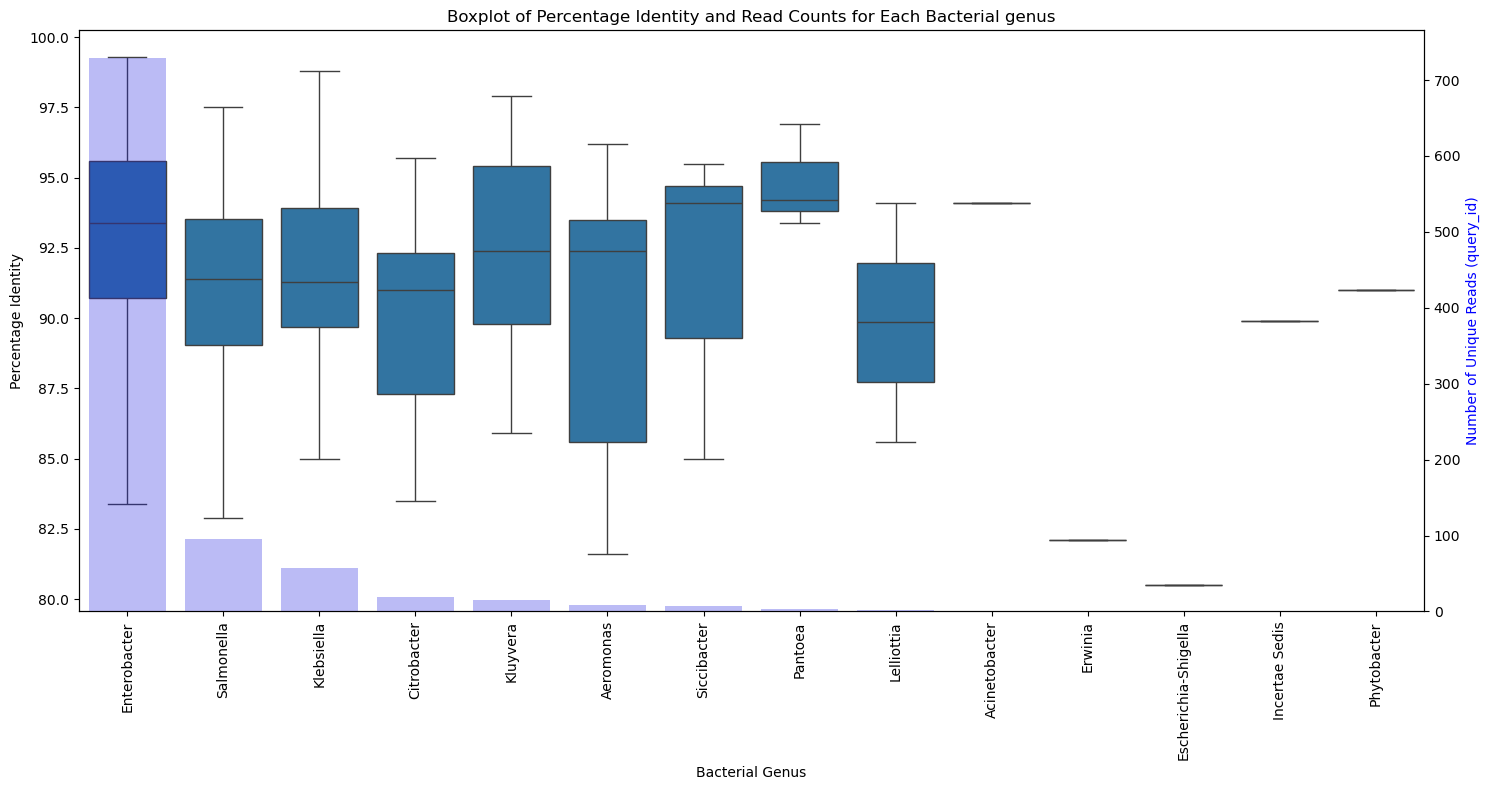

In [ ]:
# 6. Create boxplots
# Selfwritten python script "percidt_per_genus.py"
# Input: all filtered_result.csv parts of one sample
# Output: boxplot over all samples per percentage identity, number of unique hits and genera

import matplotlib.pyplot as plt
import seaborn as sns

display(Markdown(f"""
# Create boxplot
---
### 1. Parse filtered results with reduced columns, drop duplicates and merge (see cell before)
### 2. Merge split fasta parts in one dataframe\n
### 3. Groupy by AMR Gene Family and genus (export table)\n
```combined_df.groupby(['AMR Gene Family_abr', 'genus_16S']).size()```\n
### 4. Plot count per AMR Gene Family
---
## Plot abundance
"""))

def generate_percentage_idt_per_genus(input_files, output_file):
    all_data = []  # List to hold DataFrames from all input files

    for input_file in input_files:
        df = pd.read_csv(input_file, sep=",", usecols=necessary_columns, header=0)
        all_data.append(df)
        
    # Combine all partitions into a single DataFrame
    combined_data = pd.concat(all_data)
    
    # Calculate genus query counts and genus order
    genus_query_counts = combined_data.groupby('genus')['query_id'].nunique().reset_index()
    genus_query_counts.columns = ['genus', 'unique_query_count']
    combined_data = pd.merge(combined_data, genus_query_counts, on='genus')
    genus_order = genus_query_counts.sort_values(by='unique_query_count', ascending=False)['genus']
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(15, 8))
    sns.boxplot(x='genus', y='perc_identity', data=combined_data, ax=ax1, order=genus_order,fliersize=0.0)
    ax1.set_xlabel("Bacterial Genus")
    ax1.set_ylabel("Percentage Identity")
    ax1.set_title("Boxplot of Percentage Identity and Read Counts for Each Bacterial genus")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

    # Add a second y-axis for unique query counts
    ax2 = ax1.twinx()
    sns.barplot(x='genus', y='unique_query_count', data=genus_query_counts, ax=ax2, alpha=0.3, color='blue', order=genus_order)
    ax2.set_ylabel("Number of Unique Reads (query_id)", color='blue')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    input_files = ["/local/work/adrian/ERMA/results/test_epic_data/001/filtered_results.csv","/local/work/adrian/ERMA/results/test_epic_data/002/filtered_results.csv"]
    output_file = "snakemake.output[0]"
    generate_percentage_idt_per_genus(input_files, output_file)
